In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
%matplotlib inline

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
print(train_df.info())
print('*' * 20)
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Preprocessing 
* Train 데이터와 Test 데이터를 동시에 전처리 하기 위해 pandas의 concat함수를 이용하여 Big_df 생성
  * ** Missing Value 채우기 -> Feature 변환 -> Big_df를 다시 train set과 test set으로 나눔 -> Outlier 체크 -> train set Scaling **
      * Feature 변환 : Feature 차원이 너무 높으면 Overfitting 가능성 높음. => Feature의 차원을 되도록 낮게 해서 모델을 만들어야 함.
          
          
* 데이터 타입이 int이지만 object 형태의 데이터를 object 타입 데이터로 변환
* Target 값 : SalePrice(집 가격) 

In [4]:
X_feature = train_df.drop(['SalePrice'], axis=1)
X_feature.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [5]:
X_feature.loc[:, ['BsmtFullBath', 'BsmtHalfBath', 'MSSubClass']].head()

,BsmtFullBath,BsmtHalfBath,MSSubClass
0,1,0,60
1,0,1,20
2,1,0,60
3,1,0,70
4,1,0,60


In [6]:
Big_df = pd.concat([X_feature, test_df], axis=0)
Big_df.index = range(len(Big_df))
int_but_object_data =['BsmtFullBath', 'BsmtHalfBath', 'MSSubClass']

for col in int_but_object_data:
    Big_df[col] = Big_df[col].astype('object')

In [7]:
missing_value_rank = Big_df.isnull().sum() / Big_df.isnull().count()
missing_value_rank_df = pd.DataFrame(missing_value_rank, columns=['Missing Value Ratio'])
missing_value_rank_df[missing_value_rank_df['Missing Value Ratio'] > 0].sort_values('Missing Value Ratio', ascending=False)

,Missing Value Ratio
PoolQC,0.996574
MiscFeature,0.964029
Alley,0.932169
Fence,0.804385
FireplaceQu,0.486468
LotFrontage,0.166495
GarageFinish,0.054471
GarageQual,0.054471
GarageCond,0.054471
GarageYrBlt,0.054471


In [8]:
def seperate_type(df):
    dtypes = df.dtypes
    numerical = [df.columns[idx] for idx, _ in enumerate(dtypes) if dtypes[idx] != object]
    category = [df.columns[idx] for idx, _ in enumerate(dtypes) if dtypes[idx] == object]
    
    return numerical, category

numerical_feature = seperate_type(Big_df)[0]
category_feature = seperate_type(Big_df)[1]

In [9]:
print(u'수치형 데이터 Shape:', Big_df[numerical_feature].shape, '\n',
      u'범주형 데이터 Shape:', Big_df[category_feature].shape)

수치형 데이터 Shape: (2919, 34) 
 범주형 데이터 Shape: (2919, 46)


* 가격과 수치형 데이터들 간 상관관계

In [10]:
corr_data = train_df[numerical_feature].corrwith(train_df['SalePrice']).sort_values(ascending=False)
corr_df = pd.DataFrame(corr_data, columns=['Correlation'])
corr_df

,Correlation
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


* 가격과 수치형 데이터들 간 상관관계 시각화

Text(0.5, 0, 'Correlation')

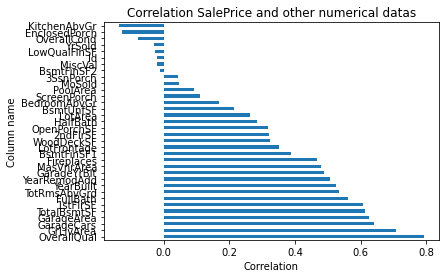

In [11]:
train_df[numerical_feature].corrwith(train_df['SalePrice']).sort_values(ascending=False).plot(kind='barh')
plt.title('Correlation SalePrice and other numerical datas')
plt.ylabel('Column name')
plt.xlabel('Correlation')

# 결측 데이터 채워 넣기

In [12]:
class fill(object):
    def __init__(self, df, lst):
        self.df = df
        self.lst = lst
        
    def fillna_median(self):
        for col_name in self.lst:
            self.df.loc[:, col_name].fillna(self.df.loc[:, col_name].median(), inplace=True)
        return self.df
    
    def fillna_mode(self):
        for col_name in self.lst:
            self.df.loc[:, col_name].fillna(self.df.loc[:, col_name].mode()[0], inplace=True)
        return self.df
    
    def fillna_year(self):
        for col_name in self.lst:
            self.df.loc[:, col_name].fillna(train_df[train_df['SalePrice'] < 200600]['GarageYrBlt'].median(), inplace=True)
        return self.df
    
    def fillna_label(self):
        for col_name in self.lst:
            self.df.loc[:, col_name].fillna('NE', inplace=True)
        return self.df
    
    def delete_columns(self):
        for col_name in self.lst:
            del self.df[col_name]
            
        return self.df

## Column 별 fill 구분
    
* 삭제하는 Column
   * 너무 NaN값이 많은 경우, 삭제하는 컬럼과 관계 있는 컬럼의 경우, Id같은 상관없다고 판단한 컬럼

In [13]:
fill_median = ['LotFrontage']
fill_mode = ['GarageCars', 'GarageArea', 'MasVnrArea', 'BsmtFinSF1', 
             'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF']

fill_year = ['GarageYrBlt']
delete_column_nu = ['MiscVal', 'PoolArea', 'Id']

fill_mode_ca = ['MSZoning','Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                'Electrical', 'KitchenQual', 'Functional', 'SaleType','BsmtFullBath', 
                'BsmtHalfBath']

fill_label = ['FireplaceQu', 'GarageType','GarageFinish', 'GarageQual','GarageCond', 
              'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

delete_column_ca = ['Alley', 'PoolQC', 'Fence', 'MiscFeature','MSSubClass']

Big_X_copy_nu = Big_df[numerical_feature].copy()
Big_X_1 = fill(Big_X_copy_nu, fill_median)
Big_X_1.fillna_median()
Big_X_1 = fill(Big_X_copy_nu, fill_mode)
Big_X_1.fillna_mode()
Big_X_1 = fill(Big_X_copy_nu, fill_year)
Big_X_1.fillna_year()
Big_X_1 = fill(Big_X_copy_nu, delete_column_nu)
Big_X_1_nu = Big_X_1.delete_columns()

Big_X_copy_ca = Big_df[category_feature].copy()
Big_X_2 = fill(Big_X_copy_ca, fill_mode_ca)
Big_X_2.fillna_mode()
Big_X_2 = fill(Big_X_copy_ca, fill_label)
Big_X_2.fillna_label()
Big_X_2 = fill(Big_X_copy_ca, delete_column_ca)
Big_X_1_ca = Big_X_2.delete_columns()

# Feature 변환

In [14]:
Big_X_1_nu.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MoSold',
       'YrSold'],
      dtype='object')

In [15]:
Big_X_1_nu[['1stFlrSF','2ndFlrSF']].head()

,1stFlrSF,2ndFlrSF
0,856,854
1,1262,0
2,920,866
3,961,756
4,1145,1053


In [16]:
Big_X_1_nu[['OpenPorchSF','EnclosedPorch', '3SsnPorch', 'ScreenPorch']].head()

,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch
0,61,0,0,0
1,0,0,0,0
2,42,0,0,0
3,35,272,0,0
4,84,0,0,0


In [17]:
Big_X_1_nu[['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']].head()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
0,706.0,0.0,150.0,856.0
1,978.0,0.0,284.0,1262.0
2,486.0,0.0,434.0,920.0
3,216.0,0.0,540.0,756.0
4,655.0,0.0,490.0,1145.0


* 1stFlrSF + 2ndFlrSF -> TotalFlrSF
* OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch -> TotalPorchSF
* TotalBsmtSF의 경우 BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF 이므로 BsmtFinSF1, BsmtFinSF2, BsmtUnfSF 삭제

In [18]:
delete_column = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']
Big_X_1 = fill(Big_X_copy_nu, delete_column)
Big_X_1_nu = Big_X_1.delete_columns()
Big_X_1_nu['TotalFlrSF'] = Big_X_1_nu['1stFlrSF'] + Big_X_1_nu['2ndFlrSF']
Big_X_1_nu['TotalPorchSF'] = Big_X_1_nu['OpenPorchSF'] + Big_X_1_nu['EnclosedPorch'] + Big_X_1_nu['3SsnPorch'] + Big_X_1_nu['ScreenPorch']
Big_X_1_nu_copy = Big_X_1_nu.drop(['1stFlrSF', '2ndFlrSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], 
                                  axis=1, inplace=False)

* ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, KitchenQual,FireplaceQu,GarageFinish, GarageQual,GarageCond

    * pandas의 replace함수를 이용하여 변환 ex) Ex : 5, Gd : 4, Ta : 3 ...
    
---    
* Electrical, LandSlope, LandContour, LotShape
    * 마찬가지로 아주 좋으면 5점, 좋으면 4점(3점) 중간(3점)(2점) 등으로 변환 

In [19]:
Big_X_1_ca.columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [20]:
Big_X_1_ca.loc[:, 'ExterQual'] = Big_X_1_ca.loc[:, 'ExterQual'].replace({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1})
Big_X_1_ca.loc[:, 'ExterCond'] = Big_X_1_ca.loc[:, 'ExterCond'].replace({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1})
Big_X_1_ca.loc[:, 'BsmtQual'] = Big_X_1_ca.loc[:, 'BsmtQual'].replace({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, 'NE' : 0})
Big_X_1_ca.loc[:, 'BsmtCond'] = Big_X_1_ca.loc[:, 'BsmtCond'].replace({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, 'NE' : 0})
Big_X_1_ca.loc[:, 'HeatingQC'] = Big_X_1_ca.loc[:, 'HeatingQC'].replace({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1})
Big_X_1_ca.loc[:, 'KitchenQual'] = Big_X_1_ca.loc[:, 'KitchenQual'].replace({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1})
Big_X_1_ca.loc[:, 'FireplaceQu'] = Big_X_1_ca.loc[:, 'FireplaceQu'].replace({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, 'NE' : 0})
Big_X_1_ca.loc[:, 'GarageFinish'] = Big_X_1_ca.loc[:, 'GarageFinish'].replace({'Fin' : 5, 'RFn' : 3, 'Unf' : 1, 'NE' : 0})
Big_X_1_ca.loc[:, 'GarageQual'] = Big_X_1_ca.loc[:, 'GarageQual'].replace({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, 'NE' : 0})
Big_X_1_ca.loc[:, 'GarageCond'] = Big_X_1_ca.loc[:, 'GarageCond'].replace({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, 'NE' : 0})
Big_X_1_ca.loc[:, 'Electrical'] = Big_X_1_ca.loc[:, 'Electrical'].replace({'SBrkr' : 5, 'FuseA' : 4, 'FuseF' : 3, 'Mix': 2, 'FuseP' : 1})
Big_X_1_ca.loc[:, 'LandSlope'] = Big_X_1_ca.loc[:, 'LandSlope'].replace({'Gtl' : 5, 'Mod' : 3, 'Sev' : 1})
Big_X_1_ca.loc[:, 'LandContour'] = Big_X_1_ca.loc[:, 'LandContour'].replace({'Lvl' : 5, 'Bnk' : 3, 'HLS' : 2, 'Low' : 1})
Big_X_1_ca.loc[:, 'BsmtExposure'] = Big_X_1_ca.loc[:, 'BsmtExposure'].replace({'Gd' : 4, 'Av' : 3, 'Mn' : 2, 'No' : 1, 'NE' : 0 })
Big_X_1_ca.loc[:, 'BsmtFinType1'] = Big_X_1_ca.loc[:, 'BsmtFinType1'].replace({'GLQ' : 6, 'ALQ' : 5, 'BLQ' : 4, 'Rec' : 3,
                                                                               'LwQ' : 2, 'Unf' : 1, 'NE' : 0})
Big_X_1_ca.loc[:, 'BsmtFinType2'] = Big_X_1_ca.loc[:, 'BsmtFinType2'].replace({'GLQ' : 6, 'ALQ' : 5, 'BLQ' : 4, 'Rec' : 3,
                                                                               'LwQ' : 2, 'Unf' : 1, 'NE' : 0})
Big_X_1_ca.loc[:, 'LotShape'] = Big_X_1_ca.loc[:, 'LotShape'].replace({'Reg' : 4, 'IR1' : 3, 'IR2' : 2, 'IR3' : 1})

In [21]:
Big_X = pd.concat([Big_X_1_nu_copy, Big_X_1_ca], axis=1)
numerical_feature = seperate_type(Big_X)[0]
categorical_feature = seperate_type(Big_X)[1]

In [22]:
Big_X[numerical_feature].columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', 'LowQualFinSF',
       'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'MoSold', 'YrSold', 'TotalFlrSF', 'TotalPorchSF',
       'LotShape', 'LandContour', 'LandSlope', 'ExterQual', 'ExterCond',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'HeatingQC', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath',
       'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual',
       'GarageCond'],
      dtype='object')

* Fireplaces X FireplaceQu => Evaluate_Fireplace
* GarageCars X GarageArea X GarageFinish X GarageQual X GarageCond => Evaluate_Garage
* KitchenAbvGr X KitchenQual => Evaluate_Kitchen
* TotalBsmtSF X BsmtQual X BsmtCond => Evaluate_Bsmt
* LandSlope X LandContour => Evaluate_Land 
* LotShape X LotArea => Evaluate_Lot

In [23]:
Big_X['Evaluate_Fireplace'] = Big_X['Fireplaces'] * Big_X['FireplaceQu']
Big_X['Evaluate_Garage'] = Big_X['GarageCars'] * Big_X['GarageArea'] * Big_X['GarageFinish'] * \
                           Big_X['GarageQual'] * Big_X['GarageCond']
Big_X['Evaluate_Kitchen'] = Big_X['KitchenAbvGr'] * Big_X['KitchenQual']
Big_X['Evaluate_Bsmt'] = Big_X['TotalBsmtSF'] * Big_X['BsmtQual'] * Big_X['BsmtCond'] * \
                            Big_X['BsmtExposure'] * Big_X['BsmtFinType1'] * Big_X['BsmtFinType2']
Big_X['Evaluate_Land'] = Big_X['LandSlope'] * Big_X['LandContour'] 
Big_X['Evaluate_Lot'] = Big_X['LotShape'] * Big_X['LotArea']
Big_X_copy = Big_X.drop(['Fireplaces','FireplaceQu', 'GarageCars', 'GarageArea', 'GarageFinish', 'GarageQual', 
                         'GarageCond', 'KitchenAbvGr', 'KitchenQual', 'TotalBsmtSF', 'BsmtQual', 'BsmtCond', 
                         'BsmtExposure','BsmtFinType1','BsmtFinType2','LandSlope','LandContour', 'LotShape',
                         'LotArea'], axis=1, inplace=False)

In [24]:
Big_X_copy.head()

,LotFrontage,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,LowQualFinSF,GrLivArea,FullBath,HalfBath,...,GarageType,PavedDrive,SaleType,SaleCondition,Evaluate_Fireplace,Evaluate_Garage,Evaluate_Kitchen,Evaluate_Bsmt,Evaluate_Land,Evaluate_Lot
0,65.0,7,5,2003,2003,196.0,0,1710,2,1,...,Attchd,Y,WD,Normal,0,29592.0,4,61632.0,25,33800
1,80.0,6,8,1976,1976,0.0,0,1262,2,0,...,Attchd,Y,WD,Normal,3,24840.0,3,302880.0,25,38400
2,68.0,7,5,2001,2002,162.0,0,1786,2,1,...,Attchd,Y,WD,Normal,3,32832.0,4,132480.0,25,33750
3,60.0,7,5,1915,1970,0.0,0,1717,1,0,...,Detchd,Y,WD,Abnorml,4,17334.0,4,45360.0,25,28650
4,84.0,8,5,2000,2000,350.0,0,2198,2,1,...,Attchd,Y,WD,Normal,3,67716.0,4,247320.0,25,42780


# 수치형 데이터 Feature들과 Target 변수 간 상관관계 시각화

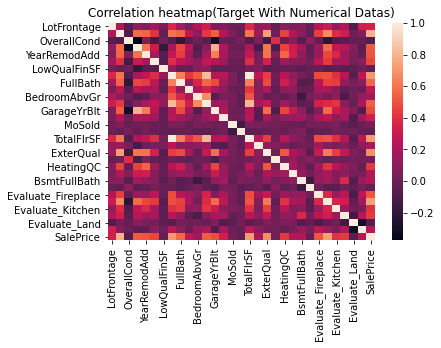

In [25]:
numerical_feature = seperate_type(Big_X_copy)[0]
analysis_data = pd.concat([Big_X_copy[numerical_feature][0:train_df.shape[0]], train_df['SalePrice']], axis=1)
corr_price_and_other = pd.DataFrame(analysis_data.loc[:,:'Evaluate_Lot'].corrwith(analysis_data['SalePrice']).sort_values(ascending=False),
                                   columns=['Correlation'])
sns.heatmap(analysis_data.corr())
plt.title('Correlation heatmap(Target With Numerical Datas)')
plt.show()

In [26]:
corr_price_and_other

,Correlation
OverallQual,0.790982
Evaluate_Garage,0.736124
TotalFlrSF,0.716883
GrLivArea,0.708624
ExterQual,0.682639
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
Evaluate_Fireplace,0.510043
YearRemodAdd,0.507101


* Target값인 SalePrice와의 Correlation 값이 낮은 변수들은 제거

In [27]:
delete_column = ['ExterCond', 'OverallCond', 'LowQualFinSF', 'MoSold', 'YrSold', 
                 'BsmtHalfBath', 'Evaluate_Land','Evaluate_Lot']
analysis_data_ = fill(analysis_data, delete_column)
analysis_data_.delete_columns().columns

Index(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
       'GarageYrBlt', 'WoodDeckSF', 'TotalFlrSF', 'TotalPorchSF', 'ExterQual',
       'HeatingQC', 'Electrical', 'BsmtFullBath', 'Evaluate_Fireplace',
       'Evaluate_Garage', 'Evaluate_Kitchen', 'Evaluate_Bsmt', 'SalePrice'],
      dtype='object')

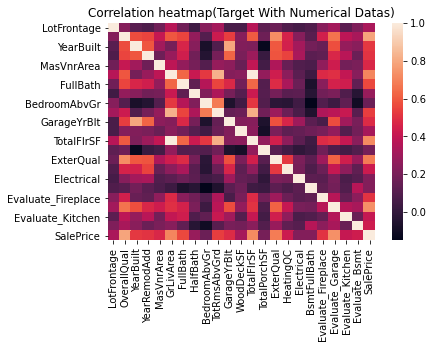

In [28]:
sns.heatmap(analysis_data.corr())
plt.title('Correlation heatmap(Target With Numerical Datas)')
plt.show()

* Target값과의 Correlation 값 내림차순정렬 데이터프레임
    * Correlation 값이 0.3 초과 인것들만 사용

,Correlation
OverallQual,0.790982
Evaluate_Garage,0.736124
TotalFlrSF,0.716883
GrLivArea,0.708624
ExterQual,0.682639
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
Evaluate_Fireplace,0.510043
YearRemodAdd,0.507101


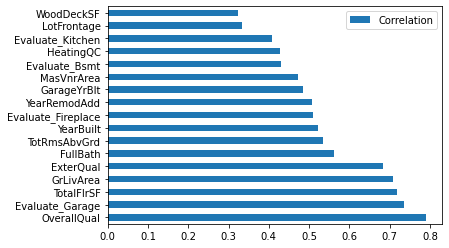

In [29]:
corr_price_and_other[corr_price_and_other['Correlation'] > 0.3].plot(kind='barh')
corr_result_nu = corr_price_and_other[corr_price_and_other['Correlation'] > 0.3]
corr_result_nu

# 범주형 데이터 Feature들과 Target 변수 간 상관관계 시각화

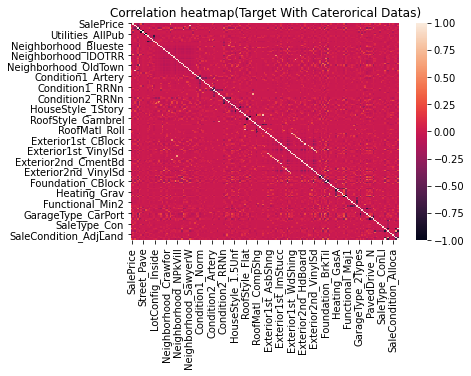

,Correlation
Foundation_PConc,0.497734
Neighborhood_NridgHt,0.402149
SaleType_New,0.357509
SaleCondition_Partial,0.352060
GarageType_Attchd,0.335961
...,...
CentralAir_N,-0.251328
MSZoning_RM,-0.288065
Foundation_CBlock,-0.343263
GarageType_Detchd,-0.354141


In [30]:
categorical_feature = seperate_type(Big_X_copy)[1]
analysis_data_ca = pd.concat([Big_X_copy[categorical_feature][0:train_df.shape[0]], train_df['SalePrice']], axis=1)

corr_price_and_other_ca = pd.DataFrame(pd.get_dummies(analysis_data_ca).loc[:,'MSZoning_C (all)':]. \
                                       corrwith(analysis_data_ca['SalePrice']).sort_values(ascending=False),columns=['Correlation'])
sns.heatmap(pd.get_dummies(analysis_data_ca).corr()) 
plt.title("Correlation heatmap(Target With Caterorical Datas)")
plt.show()
corr_price_and_other_ca

* Target값과의 Correlation 값 내림차순정렬 데이터프레임
    * Correlation 값이 0.25 초과 인것들만 사용

,Correlation
Foundation_PConc,0.497734
Neighborhood_NridgHt,0.402149
SaleType_New,0.357509
SaleCondition_Partial,0.352060
GarageType_Attchd,0.335961
MasVnrType_Stone,0.330476
Neighborhood_NoRidge,0.330424
Exterior2nd_VinylSd,0.306389
Exterior1st_VinylSd,0.305009
CentralAir_Y,0.251328


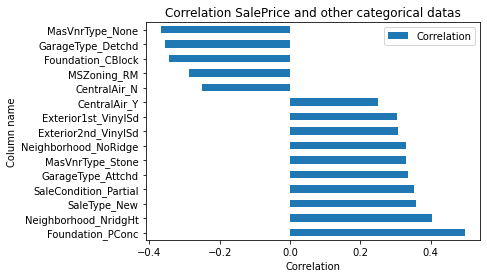

In [31]:
corr_price_and_other_ca[abs(corr_price_and_other_ca['Correlation']) > 0.25].plot(kind='barh')
plt.title('Correlation SalePrice and other categorical datas')
plt.xlabel('Correlation')
plt.ylabel('Column name')
corr_result_ca = corr_price_and_other_ca[abs(corr_price_and_other_ca['Correlation']) > 0.25]
corr_result_ca

In [32]:
Big_X_nu = Big_X[corr_result_nu.T.columns]
Big_X_ca = pd.get_dummies(Big_X)[corr_result_ca.T.columns]
Total_Big_X = pd.concat([Big_X_nu, Big_X_ca], axis=1)
Total_Big_X.columns

Index(['OverallQual', 'Evaluate_Garage', 'TotalFlrSF', 'GrLivArea',
       'ExterQual', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'Evaluate_Fireplace', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea',
       'Evaluate_Bsmt', 'HeatingQC', 'Evaluate_Kitchen', 'LotFrontage',
       'WoodDeckSF', 'Foundation_PConc', 'Neighborhood_NridgHt',
       'SaleType_New', 'SaleCondition_Partial', 'GarageType_Attchd',
       'MasVnrType_Stone', 'Neighborhood_NoRidge', 'Exterior2nd_VinylSd',
       'Exterior1st_VinylSd', 'CentralAir_Y', 'CentralAir_N', 'MSZoning_RM',
       'Foundation_CBlock', 'GarageType_Detchd', 'MasVnrType_None'],
      dtype='object')

In [33]:
Total_Big_X.head()

,OverallQual,Evaluate_Garage,TotalFlrSF,GrLivArea,ExterQual,FullBath,TotRmsAbvGrd,YearBuilt,Evaluate_Fireplace,YearRemodAdd,...,MasVnrType_Stone,Neighborhood_NoRidge,Exterior2nd_VinylSd,Exterior1st_VinylSd,CentralAir_Y,CentralAir_N,MSZoning_RM,Foundation_CBlock,GarageType_Detchd,MasVnrType_None
0,7,29592.0,1710,1710,4,2,8,2003,0,2003,...,0,0,1,1,1,0,0,0,0,0
1,6,24840.0,1262,1262,3,2,6,1976,3,1976,...,0,0,0,0,1,0,0,1,0,1
2,7,32832.0,1786,1786,4,2,6,2001,3,2002,...,0,0,1,1,1,0,0,0,0,0
3,7,17334.0,1717,1717,3,1,7,1915,4,1970,...,0,0,0,0,1,0,0,0,1,1
4,8,67716.0,2198,2198,4,2,9,2000,3,2000,...,0,1,1,1,1,0,0,0,0,0


* Train set과 Test set으로 분리

In [34]:
train_X = pd.concat([Total_Big_X[0: train_df.shape[0]], train_df['SalePrice']], axis=1)
test_X = Total_Big_X[train_df.shape[0]:]
test_X.index = range(len(test_df))

In [35]:
print('Number of train data :', len(train_X), '\n',
      'Number of test data :', len(test_X))

print('Shape of train data :', train_X.shape, '\n',
      'Shape of test data :', test_X.shape)

Number of train data : 1460 
 Number of test data : 1459
Shape of train data : (1460, 33) 
 Shape of test data : (1459, 32)


# Outlier 체크

* GrLivArea와 SalePrice 사이 관계를 시각화

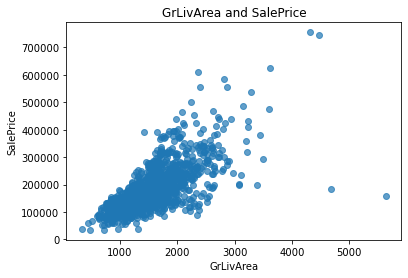

In [36]:
plt.scatter(train_X['GrLivArea'], train_X['SalePrice'], alpha=0.7)
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.title(u'GrLivArea and SalePrice')
plt.show()

train_X = train_X[train_X['GrLivArea'] <= 4000]

* 거주 면적이 커질수록 집 가격이 비싸지만 약 4700 평방피트 ~ 5400평방피트 사이의 집을 싸게 산 경우가 있다.
    * 이 경우를 Outlier로 판단할 수 있음. 
    * 그래서 거주 면적이 4000 평방피트 이하인 경우만 고려

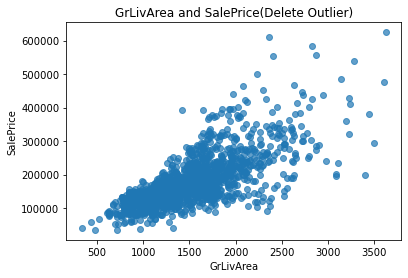

In [37]:
plt.scatter(train_X['GrLivArea'], train_X['SalePrice'], alpha=0.7)
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.title('GrLivArea and SalePrice(Delete Outlier)')
plt.show()

* LotFrontage와 SalePrice 사이 관계를 시각화

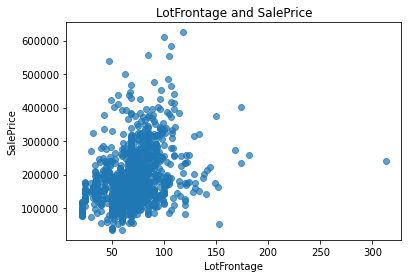

In [38]:
plt.scatter(train_X['LotFrontage'], train_X['SalePrice'], alpha=0.7)
plt.xlabel('LotFrontage')
plt.ylabel('SalePrice')
plt.title('LotFrontage and SalePrice')
plt.show()

train_X = train_X[train_X['LotFrontage'] <= 300]

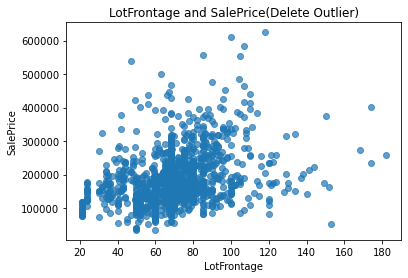

In [39]:
plt.scatter(train_X['LotFrontage'], train_X['SalePrice'], alpha=0.7)
plt.xlabel('LotFrontage')
plt.ylabel('SalePrice')
plt.title('LotFrontage and SalePrice(Delete Outlier)')
plt.show()

In [40]:
train_X.columns

Index(['OverallQual', 'Evaluate_Garage', 'TotalFlrSF', 'GrLivArea',
       'ExterQual', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'Evaluate_Fireplace', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea',
       'Evaluate_Bsmt', 'HeatingQC', 'Evaluate_Kitchen', 'LotFrontage',
       'WoodDeckSF', 'Foundation_PConc', 'Neighborhood_NridgHt',
       'SaleType_New', 'SaleCondition_Partial', 'GarageType_Attchd',
       'MasVnrType_Stone', 'Neighborhood_NoRidge', 'Exterior2nd_VinylSd',
       'Exterior1st_VinylSd', 'CentralAir_Y', 'CentralAir_N', 'MSZoning_RM',
       'Foundation_CBlock', 'GarageType_Detchd', 'MasVnrType_None',
       'SalePrice'],
      dtype='object')

* 수치형 데이터 Feature들과 Target 값인 SalePrice과의 Pairplot

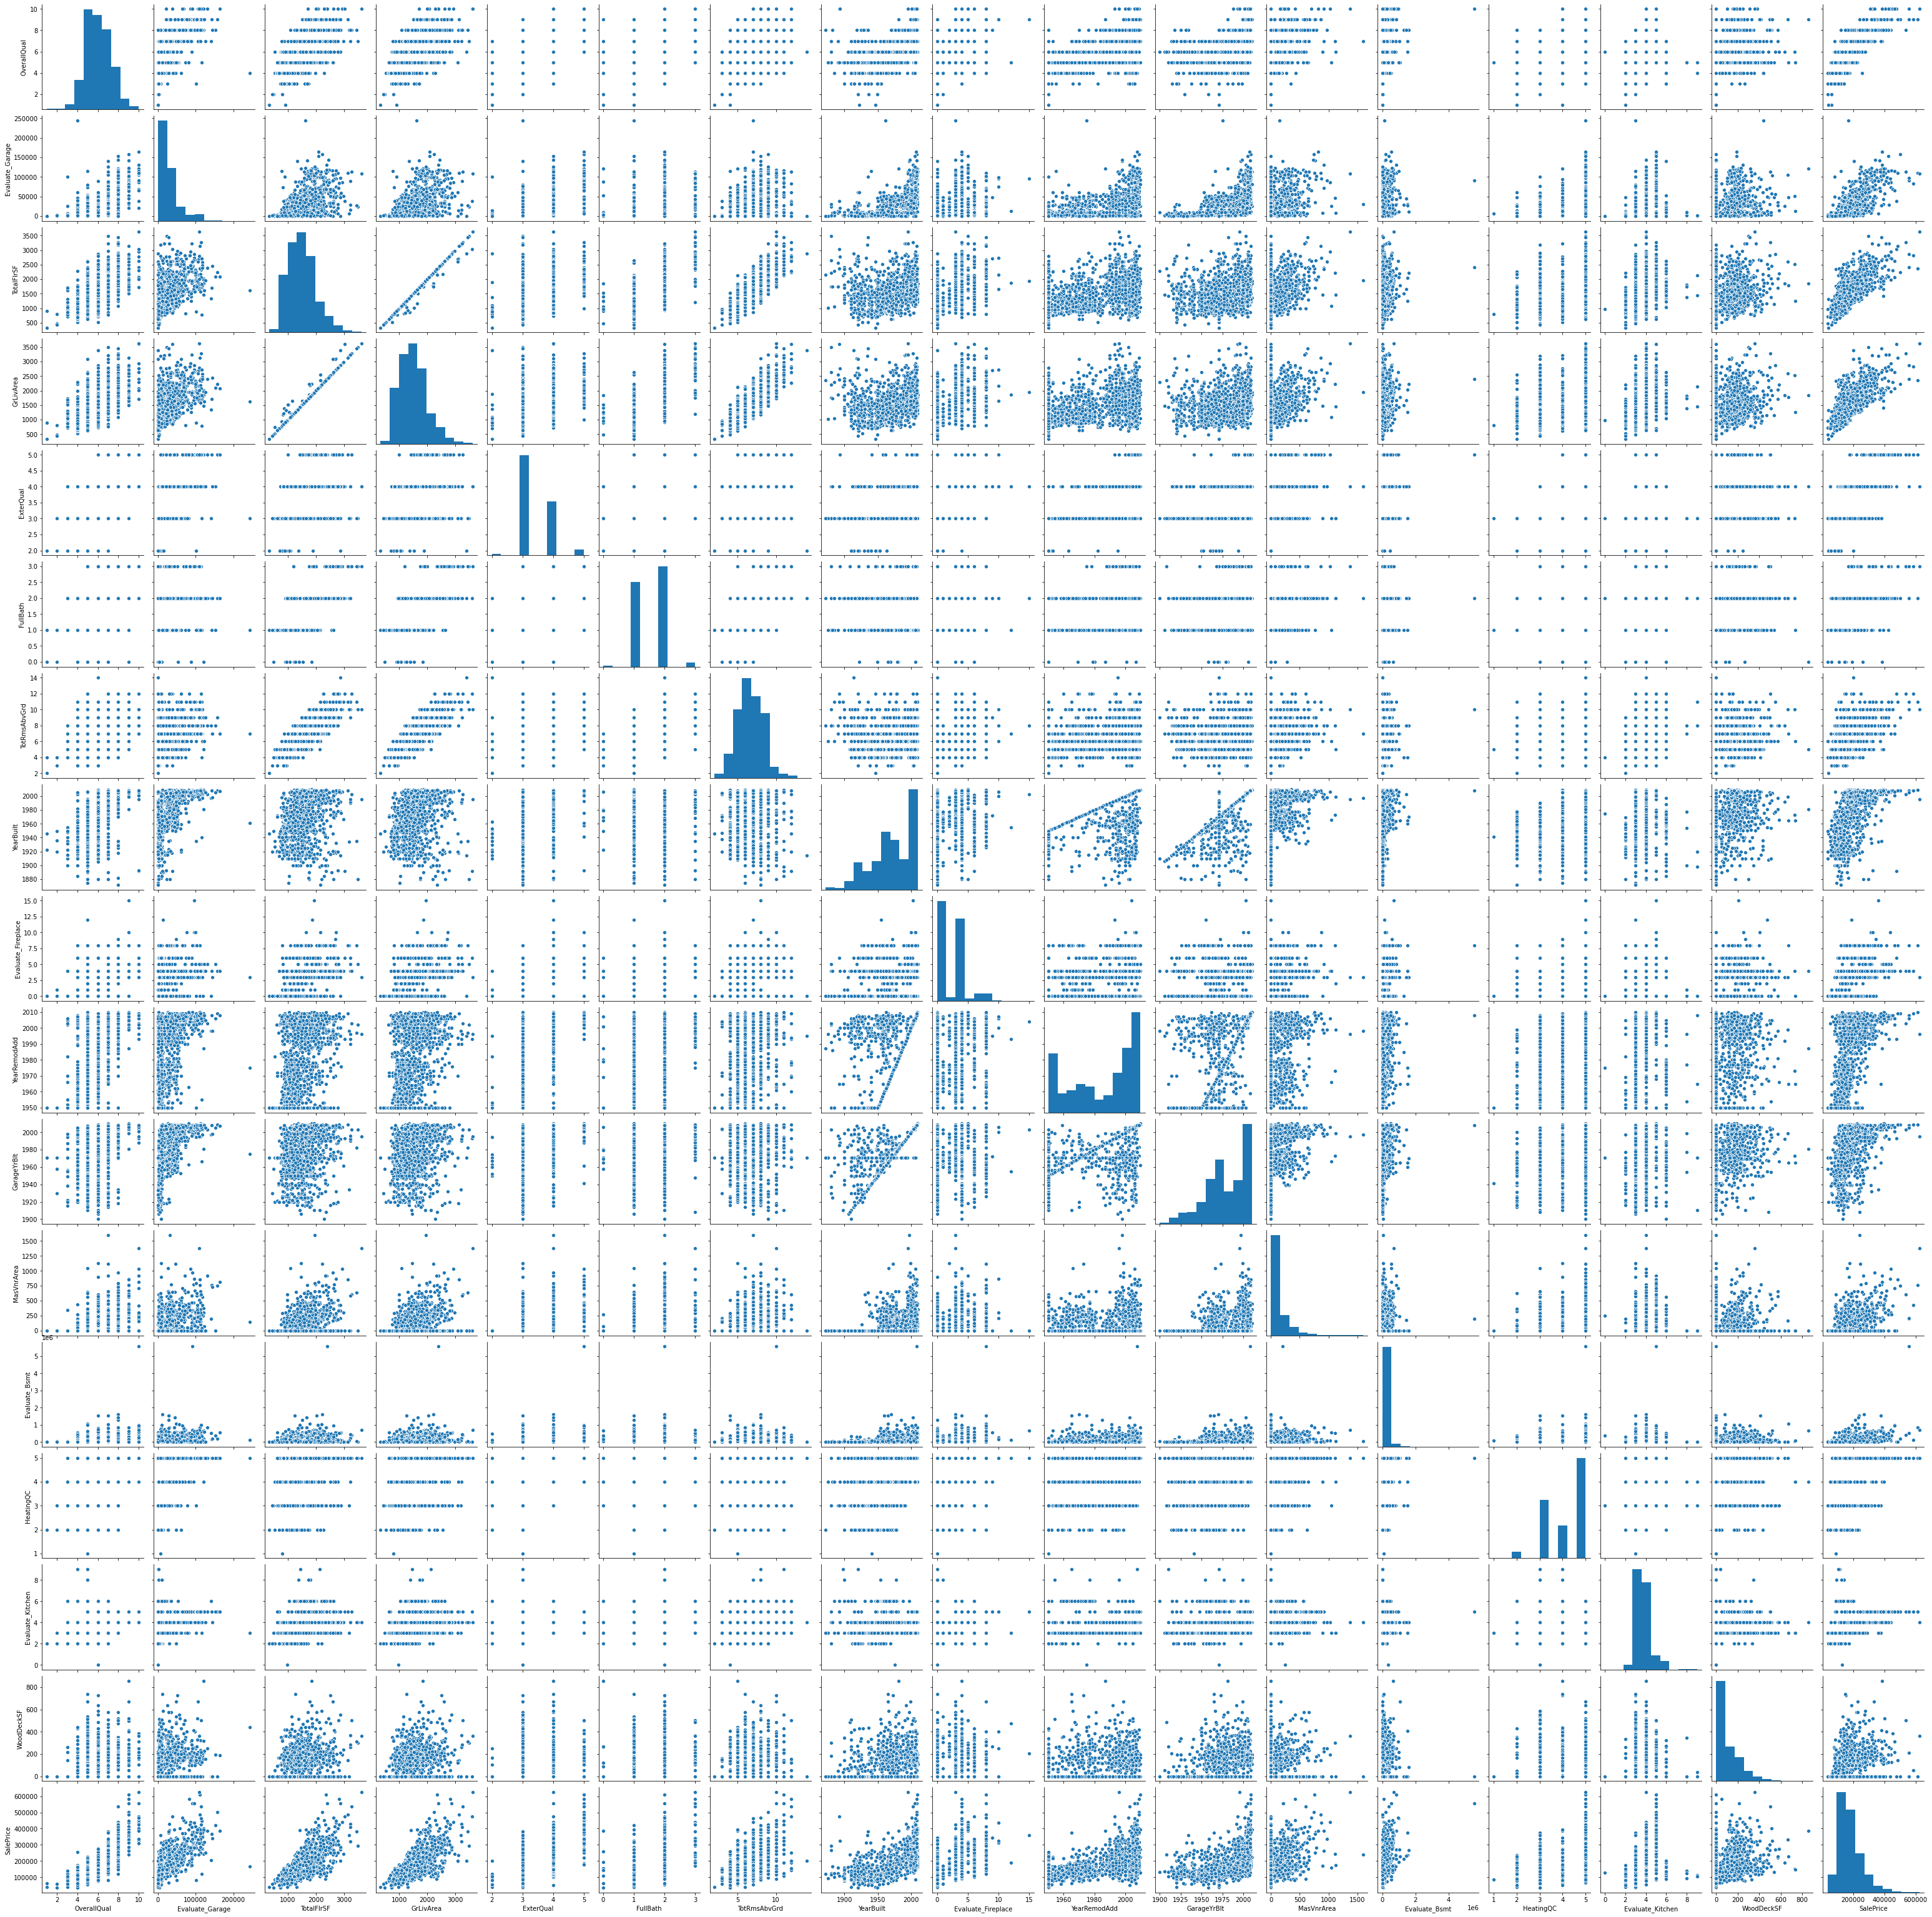

In [41]:
using_columns = ['OverallQual', 'Evaluate_Garage', 'TotalFlrSF', 'GrLivArea', 'ExterQual', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
                 'Evaluate_Fireplace', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea','Evaluate_Bsmt', 'HeatingQC', 'Evaluate_Kitchen', 
                 'WoodDeckSF','SalePrice']
sns.pairplot(train_X[using_columns])
plt.show()

In [42]:
train_X = train_X[train_X['Evaluate_Garage'] <= 200000]
train_X = train_X[train_X['Evaluate_Bsmt'] <= 4000000]

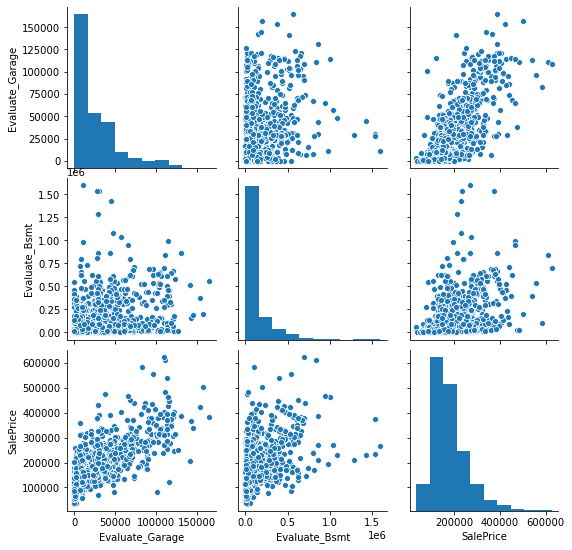

In [43]:
sns.pairplot(train_X[['Evaluate_Garage', 'Evaluate_Bsmt', 'SalePrice']])
plt.show()

* 사용 될 변수들과 Target값과의 Correlation

In [44]:
train_X.loc[:, :'MasVnrType_None'].corrwith(train_X.loc[:, 'SalePrice']).sort_values(ascending=False)

OverallQual              0.800503
Evaluate_Garage          0.760255
TotalFlrSF               0.730496
GrLivArea                0.721098
ExterQual                0.693447
FullBath                 0.561010
YearBuilt                0.536219
TotRmsAbvGrd             0.535201
YearRemodAdd             0.521904
Foundation_PConc         0.507280
Evaluate_Fireplace       0.506388
GarageYrBlt              0.498482
MasVnrArea               0.476284
Evaluate_Bsmt            0.463195
HeatingQC                0.435729
Neighborhood_NridgHt     0.411433
Evaluate_Kitchen         0.405822
SaleType_New             0.381644
SaleCondition_Partial    0.375876
LotFrontage              0.345292
MasVnrType_Stone         0.343920
GarageType_Attchd        0.340539
WoodDeckSF               0.329545
Exterior2nd_VinylSd      0.324116
Exterior1st_VinylSd      0.322881
Neighborhood_NoRidge     0.292810
CentralAir_Y             0.259267
CentralAir_N            -0.259267
MSZoning_RM             -0.295608
Foundation_CBl

# Feature들 사이 Correlation
* 사용될 독립 변수들 끼리 서로 관계가 있으면 모델에 좋지 않은 영향을 끼침
* 서로 독립이어야 함.

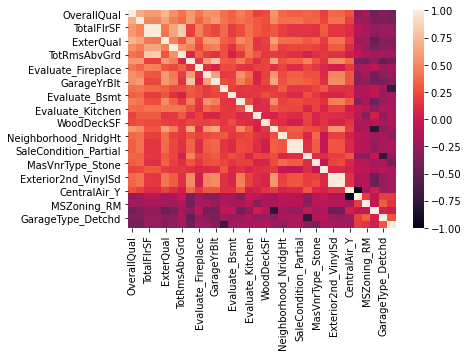

In [45]:
sns.heatmap(train_X.loc[:, :'MasVnrType_None'].corr())
plt.show()

In [46]:
train_X_copy = train_X.drop(['HeatingQC', 'FullBath', 'GarageYrBlt', 'YearRemodAdd' ,'MasVnrType_None'], axis=1)

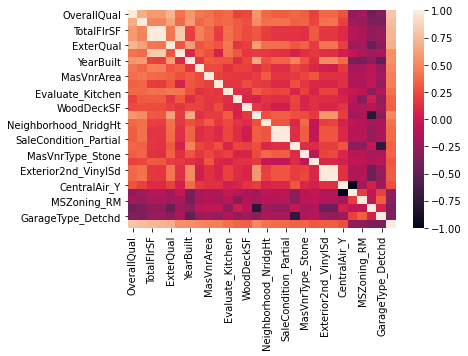

In [47]:
sns.heatmap(train_X_copy.corr())
plt.show()

In [48]:
train_X_nu = train_X_copy.loc[:, :'WoodDeckSF']
train_X_ca = train_X_copy.loc[:, 'Foundation_PConc':'GarageType_Detchd']

# Scaling 
   * MinMaxScaler

In [49]:
minmax = MinMaxScaler()
train_X_mm = minmax.fit_transform(train_X_nu)
train_X_mm_df = pd.DataFrame(train_X_mm, columns=train_X_nu.columns, index=train_X_nu.index)
train_X_fin = pd.concat([train_X_mm_df, train_X_ca], axis=1)
train_X_fin.index = range(len(train_X))

In [50]:
train_X_fin.shape

(1453, 27)

In [52]:
X_data = train_X_fin.values
target = np.log(train_X.values[:, -1])
X_train, X_test, y_train, y_test = train_test_split(X_data, target, test_size=0.3, random_state=777)
print(X_train.shape, y_train.shape)

(1017, 27) (1017,)


In [53]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [54]:
from sklearn.metrics import r2_score


print("Coefficient :", lr.coef_,
      "Intercept :", lr.intercept_)
print()
print('train(cv) r2_score :', r2_score(y_train, lr.predict(X_train)))
print('test(cv) r2_score :', r2_score(y_test, lr.predict(X_test)))

Coefficient : [ 0.64140403  0.21776082  0.47634317  0.5517113   0.14492278 -0.13800153
  0.12128816  0.17351391 -0.02255915  0.42235874  0.05584691  0.17858272
  0.12586413  0.04880132  0.02183387  0.0976534  -0.01986171  0.07509176
  0.04101131  0.00248542  0.04986184 -0.04270854  0.09095399 -0.09095399
 -0.08866317  0.02134501  0.07625835] Intercept : 10.835399367677933

train(cv) r2_score : 0.8769140487178508
test(cv) r2_score : 0.8667190558076787


* StandardScaler

In [55]:
std_scaler = StandardScaler()
train_X_std_scaler = std_scaler.fit_transform(train_X_nu)
train_X_std_scaler_df = pd.DataFrame(train_X_std_scaler, columns=train_X_nu.columns, index=train_X_nu.index)
train_X_fin_p = pd.concat([train_X_std_scaler_df, train_X_ca], axis=1)
train_X_fin_p.index = range(len(train_X))

In [57]:
X_data_2 = train_X_fin.values
target_2 = np.log(train_X.values[:, -1])
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_data_2, target_2, test_size=0.3, random_state=777)
print(X_train_p.shape, y_train_p.shape)

(1017, 27) (1017,)


In [58]:
lr_p = LinearRegression()
lr_p.fit(X_train_p, y_train_p)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [59]:
print("Coefficient :", lr_p.coef_,
      "Intercept :", lr_p.intercept_)
print()
print('train(cv) r2_score :', r2_score(y_train_p, lr_p.predict(X_train_p)))
print('test(cv) r2_score :', r2_score(y_test_p, lr_p.predict(X_test_p)))

Coefficient : [ 0.64140403  0.21776082  0.47634317  0.5517113   0.14492278 -0.13800153
  0.12128816  0.17351391 -0.02255915  0.42235874  0.05584691  0.17858272
  0.12586413  0.04880132  0.02183387  0.0976534  -0.01986171  0.07509176
  0.04101131  0.00248542  0.04986184 -0.04270854  0.09095399 -0.09095399
 -0.08866317  0.02134501  0.07625835] Intercept : 10.835399367677933

train(cv) r2_score : 0.8769140487178508
test(cv) r2_score : 0.8667190558076787
